Optimal epsilon = 0.00000
x_vals (hX) =  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2.]
Shapely polygon is_empty?  False
Polygon area = 12.606899629720028


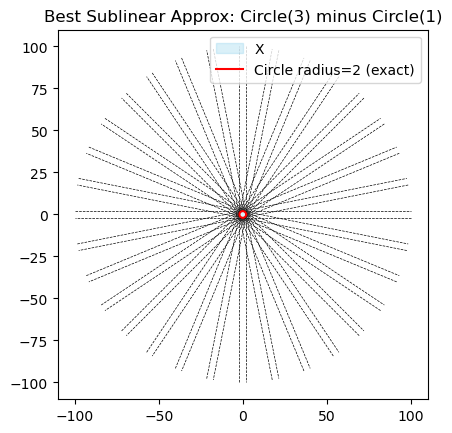

In [4]:
import numpy as np
import pulp
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def solve_sublinear_approx(f_vals, directions):
    """
    Solve the LP:
        minimize  eps
    subject to:
        |x_i - f_i| <= eps,  for all i
        subadditivity: x_k * ||u_i+u_j|| <= x_i + x_j
                       whenever u_k = (u_i+u_j)/||u_i+u_j|| in directions
    Returns (eps_val, x_vals).
    """
    m = len(directions)
    
    # Create the LP
    prob = pulp.LpProblem("BestSublinearApprox", sense=pulp.LpMinimize)
    
    # Decision variables
    eps = pulp.LpVariable('eps', lowBound=0.0, cat=pulp.LpContinuous)  # >= 0
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None, cat=pulp.LpContinuous)
              for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps
    for i in range(m):
        prob += x_vars[i] - f_vals[i] <= eps
        prob += f_vals[i] - x_vars[i] <= eps
    
    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            w = sum_vec / norm_sum  # normalized direction
            # find whichever direction in our set is closest to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            # If close enough, enforce subadditivity
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    # Solve
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(xv) for xv in x_vars], dtype=float)
    
    return eps_val, x_vals

def build_polygon_from_support(directions, x_vals):
    """
    Given directions u_i (unit) and support values x_vals = hX(u_i),
    build the intersection of half-planes <x, u_i> <= x_vals[i].
    We'll do it in 2D using a big bounding square and repeated clipping.
    """
    from shapely.geometry import Polygon
    
    INF = 1e4
    # Start with large bounding box
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        # Build a half-plane as a polygon
        # The boundary line is <x,u_i> = alpha, keep <x,u_i> <= alpha
        # We'll pick two big points on that line, then close the polygon behind it
        perp = np.array([-u_i[1], u_i[0]])  # perpendicular
        p0 = alpha*u_i  # a point on the boundary
        big = 2*INF
        A = p0 + big*perp
        B = p0 - big*perp
        
        # The 'behind' side is minus direction of u_i
        C1 = A - big*u_i
        C2 = B - big*u_i
        
        halfplane_poly = Polygon([A, B, C2, C1])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    
    return region

def main():
    # 1) Define A, B as circles of radius 3 and 1 => f(u)=3-1=2
    # but let's do the entire algorithm that doesn't assume we know it's sublinear.
    
    # Sample directions on the unit circle:
    m = 32
    angles = np.linspace(0, 2*np.pi, m, endpoint=False)
    directions = [np.array([np.cos(a), np.sin(a)]) for a in angles]
    
    # For each direction, f(u)=hA(u)-hB(u) = 3 - 1 = 2
    f_vals = np.full(m, 2.0)
    
    # 2) Solve sublinear approximation LP
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.5f}")
    
    # 3) Reconstruct polygon
    polyX = build_polygon_from_support(directions, x_vals)
    
    # 4) Print results
    print("x_vals (hX) = ", x_vals)
    print("Shapely polygon is_empty? ", polyX.is_empty)
    if not polyX.is_empty:
        print("Polygon area =", polyX.area)
    
    # 5) Plot
    fig, ax = plt.subplots()
    
    # -- Plot the polygon X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            x,y = polyX.exterior.xy
            ax.fill(x, y, alpha=0.3, color='skyblue', label='X')
        else:
            # handle MultiPolygon etc.
            for g in polyX.geoms:
                x,y = g.exterior.xy
                ax.fill(x, y, alpha=0.3, color='skyblue', label='X_part')
    
    # Optionally, also plot boundary lines <x,u_i>=x_vals[i]
    for i, d in enumerate(directions):
        # line <x,d> = x_vals[i], with a point p0 = x_vals[i]*d
        p0 = x_vals[i]*d
        perp = np.array([-d[1], d[0]])
        dist = 100
        A = p0 + dist*perp
        B = p0 - dist*perp
        ax.plot([A[0], B[0]], [A[1], B[1]], 'k--', linewidth=0.5)
    
    # Also, let's overlay the "true" circle of radius 2 just for reference
    circle_t = np.linspace(0, 2*np.pi, 200)
    circle_x = 2*np.cos(circle_t)
    circle_y = 2*np.sin(circle_t)
    ax.plot(circle_x, circle_y, 'r', label='Circle radius=2 (exact)')
    
    ax.set_aspect('equal', 'box')
    ax.set_title("Best Sublinear Approx: Circle(3) minus Circle(1)")
    ax.legend()
    plt.show()

if __name__=="__main__":
    main()


Optimal epsilon = 0.00000
x_vals (hX) =  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2.]
Shapely polygon is_empty?  False
Polygon area = 12.606899629720028


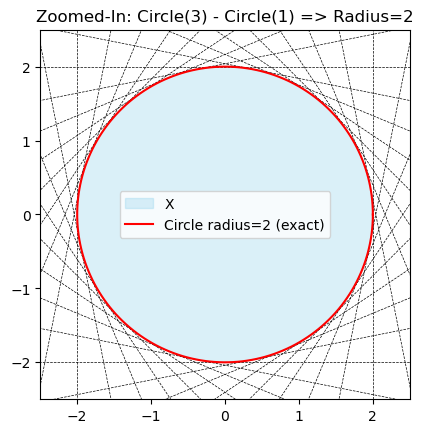

In [5]:
import numpy as np
import pulp
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def solve_sublinear_approx(f_vals, directions):
    """
    Solve the LP:
        minimize  eps
    subject to:
        |x_i - f_i| <= eps,  for all i
        subadditivity: x_k * ||u_i+u_j|| <= x_i + x_j
                       whenever u_k = (u_i+u_j)/||u_i+u_j|| in directions
    Returns (eps_val, x_vals).
    """
    m = len(directions)
    
    # Create the LP
    prob = pulp.LpProblem("BestSublinearApprox", sense=pulp.LpMinimize)
    
    # Decision variables
    eps = pulp.LpVariable('eps', lowBound=0.0, cat=pulp.LpContinuous)  # >= 0
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None, cat=pulp.LpContinuous)
              for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps
    for i in range(m):
        prob += x_vars[i] - f_vals[i] <= eps
        prob += f_vals[i] - x_vars[i] <= eps
    
    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            w = sum_vec / norm_sum  # normalized direction
            # find whichever direction in our set is closest to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            # If close enough, enforce subadditivity
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    # Solve
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(xv) for xv in x_vars], dtype=float)
    
    return eps_val, x_vals

def build_polygon_from_support(directions, x_vals):
    """
    Given directions u_i (unit) and support values x_vals = hX(u_i),
    build the intersection of half-planes <x, u_i> <= x_vals[i].
    We'll do it in 2D using a big bounding square and repeated clipping.
    """
    from shapely.geometry import Polygon
    
    INF = 1e4
    # Start with large bounding box
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        # Build a half-plane as a polygon
        perp = np.array([-u_i[1], u_i[0]])  # perpendicular
        p0 = alpha*u_i  # a point on the boundary
        big = 2*INF
        A = p0 + big*perp
        B = p0 - big*perp
        
        C1 = A - big*u_i
        C2 = B - big*u_i
        
        halfplane_poly = Polygon([A, B, C2, C1])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    
    return region

def main():
    # Define circles: A radius=3, B radius=1 => f(u)=2
    m = 32
    angles = np.linspace(0, 2*np.pi, m, endpoint=False)
    directions = [np.array([np.cos(a), np.sin(a)]) for a in angles]
    
    f_vals = np.full(m, 2.0)  # always 2
    
    # Solve sublinear approximation LP
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.5f}")
    
    # Reconstruct polygon
    polyX = build_polygon_from_support(directions, x_vals)
    
    # Print results
    print("x_vals (hX) = ", x_vals)
    print("Shapely polygon is_empty? ", polyX.is_empty)
    if not polyX.is_empty:
        print("Polygon area =", polyX.area)
    
    # Plot
    fig, ax = plt.subplots()
    
    # Plot polygon X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            x,y = polyX.exterior.xy
            ax.fill(x, y, alpha=0.3, color='skyblue', label='X')
        else:
            for g in polyX.geoms:
                x,y = g.exterior.xy
                ax.fill(x, y, alpha=0.3, color='skyblue', label='X_part')
    
    # Plot boundary lines <x,d> = x_vals[i]
    for i, d in enumerate(directions):
        p0 = x_vals[i]*d
        perp = np.array([-d[1], d[0]])
        length = 100
        A = p0 + length*perp
        B = p0 - length*perp
        ax.plot([A[0], B[0]], [A[1], B[1]], 'k--', linewidth=0.5)
    
    # Also plot the exact circle of radius 2 for reference
    circle_t = np.linspace(0, 2*np.pi, 200)
    circle_x = 2*np.cos(circle_t)
    circle_y = 2*np.sin(circle_t)
    ax.plot(circle_x, circle_y, 'r', label='Circle radius=2 (exact)')
    
    # Force equal aspect ratio
    ax.set_aspect('equal', 'box')
    
    # Zoom in around [-2.5, 2.5]
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    
    ax.set_title("Zoomed-In: Circle(3) - Circle(1) => Radius=2")
    ax.legend()
    plt.show()

if __name__=="__main__":
    main()


Optimal epsilon = 0.140329
X is empty? False
X area = 0.024904935056398767


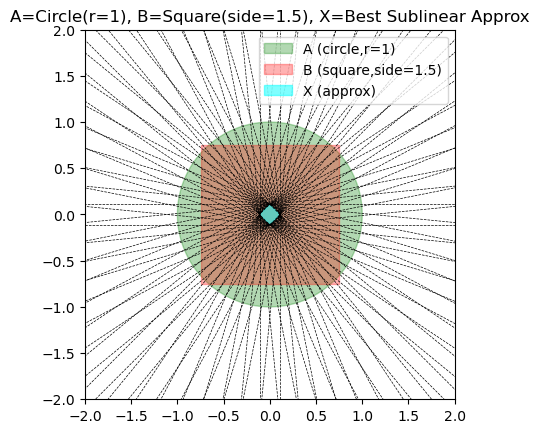

In [6]:
import numpy as np
import math
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def support_circle(u, radius=1.0):
    """
    Support function h_A(u) for a circle of given 'radius'
    (centered at origin).
    Since it's a circle, h_A(u) = radius * ||u||,
    but we assume u is already unit => h_A(u) = radius.
    """
    return radius

def support_square(u, side=1.5):
    """
    Support function h_B(u) for a square of side length 'side'
    (centered at origin, axis-aligned).
    Half-side = side/2.
    For an axis-aligned square Q = [-s, s]^2, 
    the support function in direction (ux,uy) is
         s*(|ux| + |uy|)
    Here s = side/2.
    """
    s = side/2.0
    ux, uy = u
    return s*(abs(ux) + abs(uy))

def solve_sublinear_approx(f_vals, directions):
    """
    Solve the LP:
        min eps
        s.t.  |x_i - f_i| <= eps,   for i=1..m
              subadditivity: x_k * ||u_i + u_j|| <= x_i + x_j
                             if  u_k ~ (u_i+u_j)/||u_i+u_j||
    Returns (eps_value, x_vals).
    """
    m = len(directions)
    prob = pulp.LpProblem("BestSublinearApprox2D", sense=pulp.LpMinimize)
    
    # Decision variables
    eps = pulp.LpVariable('eps', lowBound=0.0, cat=pulp.LpContinuous)  # >= 0
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None, cat=pulp.LpContinuous)
              for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation: |x_i - f_i| <= eps
    for i in range(m):
        fi = f_vals[i]
        prob += x_vars[i] - fi <= eps
        prob += fi - x_vars[i] <= eps
    
    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            w = sum_vec / norm_sum  # normalized
            # find the best match k for w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            # if close enough, impose subadditivity
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    # Solve
    solver = pulp.PULP_CBC_CMD(msg=False)
    result = prob.solve(solver)
    
    status = pulp.LpStatus[result]
    if status != "Optimal":
        print("Warning: LP not optimal. Status =", status)
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(xv) for xv in x_vars], dtype=float)
    
    return eps_val, x_vals


def build_polygon_from_support(directions, x_vals):
    """
    Reconstruct 2D polygon as intersection of half-planes:
       { x : <x, directions[i]> <= x_vals[i] }.
    We'll do it by starting with a big bounding box and clipping.
    """
    INF = 1e4
    region = Polygon([(-INF,-INF), (INF,-INF), (INF,INF), (-INF,INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        # line: <x, u_i> = alpha
        # keep side < x,u_i> <= alpha
        # We'll build a big trapezoid that covers that half-plane
        perp = np.array([-u_i[1], u_i[0]])
        big = 2*INF
        
        # A point on the boundary line
        p0 = alpha * u_i
        A = p0 + big*perp
        B = p0 - big*perp
        
        # "behind" the line in direction -u_i
        C = A - big*u_i
        D = B - big*u_i
        
        halfplane_poly = Polygon([A, B, D, C])
        region = region.intersection(halfplane_poly)
        
        if region.is_empty:
            break
    
    return region

def create_circle_polygon(radius=1.0, num_points=200):
    """
    Create a shapely Polygon for a circle (approx) of given radius
    at origin, with num_points around the boundary.
    """
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    coords = [(radius*np.cos(a), radius*np.sin(a)) for a in angles]
    return Polygon(coords)

def create_square_polygon(side=1.5):
    """
    Shapely polygon for an axis-aligned square of side 'side',
    centered at origin => corners at (+/- side/2, +/- side/2).
    """
    s = side/2.0
    coords = [(-s,-s), (s,-s), (s,s), (-s,s)]
    return Polygon(coords)

def main():
    # 1) Setup: A is circle radius=1, B is square side=1.5
    #    Both centered at origin.
    
    # We'll define their support functions:
    #    h_A(u) = 1
    #    h_B(u) = 0.75 * (|u_x| + |u_y|)
    # so f(u)= 1 - 0.75(|u_x|+|u_y|)
    
    # 2) Sample directions
    m = 64
    angles = np.linspace(0, 2*np.pi, m, endpoint=False)
    directions = np.array([[np.cos(a), np.sin(a)] for a in angles])
    
    # 3) Compute f(u) for each direction
    #    Circle radius=1 => hA(u)=1
    #    Square side=1.5 => half side=0.75 => hB(u)=0.75*(|u_x|+|u_y|)
    #    => f(u)=1 - 0.75*(|u_x|+|u_y|)
    f_vals = []
    for d in directions:
        hA = support_circle(d, radius=1.0)
        hB = support_square(d, side=1.5)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # 4) Solve the sublinear approximation LP
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}")
    
    # 5) Reconstruct X from x_vals
    polyX = build_polygon_from_support(directions, x_vals)
    print("X is empty?", polyX.is_empty)
    if not polyX.is_empty:
        print("X area =", polyX.area)
    
    # 6) Build polygons for A and B (for plotting)
    circleA = create_circle_polygon(radius=1.0)
    squareB = create_square_polygon(side=1.5)
    
    # 7) Plot everything
    fig, ax = plt.subplots()
    
    # Plot A
    if not circleA.is_empty:
        xA,yA = circleA.exterior.xy
        ax.fill(xA, yA, alpha=0.3, color='green', label='A (circle,r=1)')
    
    # Plot B
    if not squareB.is_empty:
        xB,yB = squareB.exterior.xy
        ax.fill(xB, yB, alpha=0.3, color='red', label='B (square,side=1.5)')
    
    # Plot X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX,yX = polyX.exterior.xy
            ax.fill(xX, yX, alpha=0.5, color='cyan', label='X (approx)')
        else:
            # for multipolygons, etc.
            for g in polyX.geoms:
                xX,yX = g.exterior.xy
                ax.fill(xX, yX, alpha=0.5, color='cyan', label='X part')
    
    # Optionally, plot lines <x,d>=x_vals[i]
    for i,d in enumerate(directions):
        p0 = x_vals[i]*d
        perp = np.array([-d[1], d[0]])
        L = 5
        A = p0 + L*perp
        B = p0 - L*perp
        ax.plot([A[0], B[0]], [A[1], B[1]], 'k--', lw=0.5)
    
    ax.set_aspect('equal', 'box')
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_title("A=Circle(r=1), B=Square(side=1.5), X=Best Sublinear Approx")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()


Optimal epsilon = 0.233368
X is empty: False
Area of X = 6.912387594422152


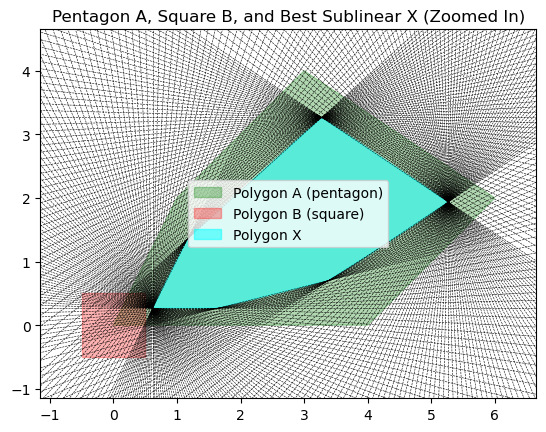

In [13]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# ------------------------------------------------------------------------
# 1) Define the polygons (A: pentagon, B: square)
#    Coordinates in (roughly) counterclockwise order
# ------------------------------------------------------------------------
A_coords = [(0, 0), (4, 0), (6, 2), (3, 4), (1, 2)]  # A is a pentagon
B_coords = [(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)]  # B is a square

polyA = Polygon(A_coords)
polyB = Polygon(B_coords)

# ------------------------------------------------------------------------
# 2) Support function for a polygon in 2D
# ------------------------------------------------------------------------
def support_polygon(u, coords):
    """
    support_polygon(u, coords) = max_{v in coords} <u, v>.
    'coords' is a list of (x,y) for a convex polygon.
    'u' is a 2D direction (numpy array).
    """
    return max(np.dot(u, v) for v in coords)

# ------------------------------------------------------------------------
# 3) Sample directions on the unit circle
# ------------------------------------------------------------------------
def sample_directions(num_dirs=64):
    """
    Return a list of num_dirs unit vectors evenly spaced around the circle.
    """
    angles = np.linspace(0, 2*np.pi, num_dirs, endpoint=False)
    dirs = [np.array([np.cos(a), np.sin(a)]) for a in angles]
    return dirs

# ------------------------------------------------------------------------
# 4) Solve the "best sublinear approximation" LP
# ------------------------------------------------------------------------
def solve_sublinear_approx(f_vals, directions):
    """
    f_vals[i] = f(u_i)
    directions[i] = unit vector u_i
    Returns (eps_value, x_values) 
      where x_values[i] ~ h_X(u_i).
    """
    m = len(directions)
    
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)
    
    # Decision variables
    eps = pulp.LpVariable('eps', lowBound=0.0)  # >= 0
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None) for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps
    
    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            w = sum_vec / norm_sum  # normalized direction
            # find best match k
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(var) for var in x_vars], dtype=float)
    return eps_val, x_vals

# ------------------------------------------------------------------------
# 5) Build polygon X from the computed support function x_vals
# ------------------------------------------------------------------------
def build_polygon_from_support(directions, x_vals):
    """
    Intersection of half-planes <x, u_i> <= x_vals[i].
    We do it in 2D via shapely.
    """
    from shapely.geometry import Polygon
    
    INF = 1e4
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2*INF
        p0 = alpha*u_i
        A = p0 + big*perp
        B = p0 - big*perp
        C = A - big*u_i
        D = B - big*u_i
        
        halfplane_poly = Polygon([A, B, D, C])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    
    return region

# ------------------------------------------------------------------------
# 6) Main function: compute & plot everything (zoom in on the shapes)
# ------------------------------------------------------------------------
def main():
    # Sample directions
    directions = sample_directions(num_dirs=256)
    
    # Compute f(u) = hA(u) - hB(u)
    f_vals = []
    for d in directions:
        hA = support_polygon(d, A_coords)
        hB = support_polygon(d, B_coords)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # Solve LP
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}")
    
    # Build X
    polyX = build_polygon_from_support(directions, x_vals)
    print("X is empty:", polyX.is_empty)
    if not polyX.is_empty:
        print("Area of X =", polyX.area)
    
    # Plot A, B, and X
    fig, ax = plt.subplots()
    
    # Plot A
    xA, yA = polyA.exterior.xy
    ax.fill(xA, yA, color='green', alpha=0.3, label='Polygon A (pentagon)')
    
    # Plot B
    xB, yB = polyB.exterior.xy
    ax.fill(xB, yB, color='red', alpha=0.3, label='Polygon B (square)')
    
    # Plot X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        else:
            for g in polyX.geoms:
                xX, yX = g.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X (part)')
    
    # Optionally, draw dashed boundary lines <x,d> = x_vals[i]
    for i,d in enumerate(directions):
        p0 = x_vals[i]*d
        perp = np.array([-d[1], d[0]])
        L = 100
        A_ = p0 + L*perp
        B_ = p0 - L*perp
        ax.plot([A_[0], B_[0]], [A_[1], B_[1]], 'k--', lw=0.4)
    
    # Force equal aspect
    ax.set_aspect('equal', 'box')
    
    # -------------- ZOOM IN --------------
    # 1) Combine all shapes (A,B,X) into one bounding geometry
    union_all = polyA.union(polyB).union(polyX)
    # 2) Get bounding box
    minx, miny, maxx, maxy = union_all.bounds  # (min_x, min_y, max_x, max_y)
    # 3) Add a small margin around
    width = maxx - minx
    height = maxy - miny
    margin = 0.1 * max(width, height)
    ax.set_xlim(minx - margin, maxx + margin)
    ax.set_ylim(miny - margin, maxy + margin)
    
    ax.set_title("Pentagon A, Square B, and Best Sublinear X (Zoomed In)")
    ax.legend()
    
    plt.show()

if __name__ == "__main__":
    main()


Optimal epsilon = 1.0
x_vals (first few) = [0. 0. 0. 0. 0.]
geom_type of X: Point
Is X empty? False


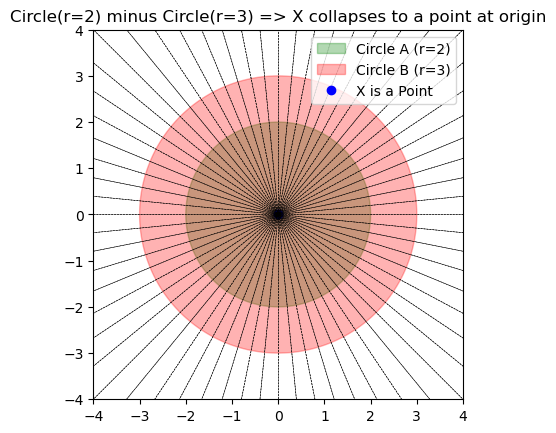

In [12]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def circle_polygon(radius=1.0, n=200):
    """
    Return a shapely Polygon approximating a circle of given 'radius',
    centered at origin, with 'n' points around the boundary.
    """
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    coords = [(radius*np.cos(a), radius*np.sin(a)) for a in angles]
    return Polygon(coords)

def solve_sublinear_approx(f_vals, directions):
    """
    Solve the LP:
        minimize  eps
        subject to
          |x_i - f_i| <= eps, for each direction i
          subadditivity: x_k * ||u_i + u_j|| <= x_i + x_j
    Returns (eps_value, x_vals) 
    where x_vals[i] is the sublinear function h_X(u_i).
    """
    m = len(directions)
    
    # Create LP problem
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)
    
    # Decision variables
    eps = pulp.LpVariable('eps', lowBound=0.0)  # >= 0
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None) for i in range(m)]
    
    # Objective: minimize eps
    prob += eps
    
    # Uniform-approx constraints: |x_i - f_i| <= eps
    for i in range(m):
        fi = f_vals[i]
        prob += x_vars[i] - fi <= eps
        prob += fi - x_vars[i] <= eps
    
    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            w = sum_vec / norm_sum
            # find k s.t. directions[k] ~ w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    # Solve
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    status = pulp.LpStatus[result]
    if status != "Optimal":
        print("Warning: LP not optimal. Status =", status)
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(xv) for xv in x_vars], dtype=float)
    return eps_val, x_vals

def build_polygon_from_support(directions, x_vals):
    """
    Build the intersection of half-planes <x, u_i> <= x_vals[i] using shapely.
    This can return a Polygon, MultiPolygon, Point, or empty geometry.
    """
    INF = 1e4
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2*INF
        
        # A point on the boundary line
        p0 = alpha*u_i
        A = p0 + big*perp
        B = p0 - big*perp
        # "behind" the line
        C = A - big*u_i
        D = B - big*u_i
        
        halfplane_poly = Polygon([A, B, D, C])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    
    return region

def main():
    # Example: Circle A radius=2, Circle B radius=3 => f(u)=2-3=-1 => best sublinear => single point
    circleA = circle_polygon(radius=2.0, n=300)
    circleB = circle_polygon(radius=3.0, n=300)
    
    # Let's sample directions
    m = 64
    angles = np.linspace(0, 2*np.pi, m, endpoint=False)
    directions = [np.array([np.cos(a), np.sin(a)]) for a in angles]
    
    # Compute f(u)=hA(u)-hB(u) => 2 - 3 = -1
    f_vals = []
    for _ in directions:
        f_vals.append(-1.0)
    f_vals = np.array(f_vals)
    
    # Solve the LP
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val}")
    print(f"x_vals (first few) = {x_vals[:5]}")
    
    # Build geometry for X
    polyX = build_polygon_from_support(directions, x_vals)
    print("geom_type of X:", polyX.geom_type)
    print("Is X empty?", polyX.is_empty)
    
    # Plot
    fig, ax = plt.subplots()
    
    # Plot A
    if not circleA.is_empty:
        xA, yA = circleA.exterior.xy
        ax.fill(xA, yA, color='green', alpha=0.3, label='Circle A (r=2)')
    
    # Plot B
    if not circleB.is_empty:
        xB, yB = circleB.exterior.xy
        ax.fill(xB, yB, color='red', alpha=0.3, label='Circle B (r=3)')
    
    # Now handle X: can be Polygon, MultiPolygon, Point, or empty
    if polyX.is_empty:
        print("X is empty geometry => no fill.")
        # However, if x_vals ~ 0 => single point at origin.
        # Let's see if that's the case:
        if np.allclose(x_vals, 0.0, atol=1e-6):
            print("But x_vals ~ 0 => shape is a single point at origin.")
            ax.plot(0, 0, 'bo', label='X = {origin}')
    else:
        gtype = polyX.geom_type
        if gtype == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='X polygon')
        elif gtype == 'MultiPolygon':
            for geom in polyX.geoms:
                xX, yX = geom.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5, label='X sub-polygon')
        elif gtype == 'Point':
            # Just plot a small circle at that point
            px, py = polyX.x, polyX.y
            ax.plot(px, py, 'bo', label='X is a Point')
        else:
            print(f"X is '{gtype}', not directly handled.")
    
    # Optionally draw boundary lines <x,d> = x_vals[i]
    for i,d in enumerate(directions):
        p0 = x_vals[i]*d
        perp = np.array([-d[1], d[0]])
        length = 200
        A_ = p0 + length*perp
        B_ = p0 - length*perp
        ax.plot([A_[0], B_[0]], [A_[1], B_[1]], 'k--', lw=0.4)
    
    ax.set_aspect('equal', 'box')
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_title("Circle(r=2) minus Circle(r=3) => X collapses to a point at origin")
    ax.legend()
    plt.show()

if __name__=="__main__":
    main()


Optimal eps = 0.031224
X geom_type: Polygon
X is empty?  False
Area of X: 5.475702759278843


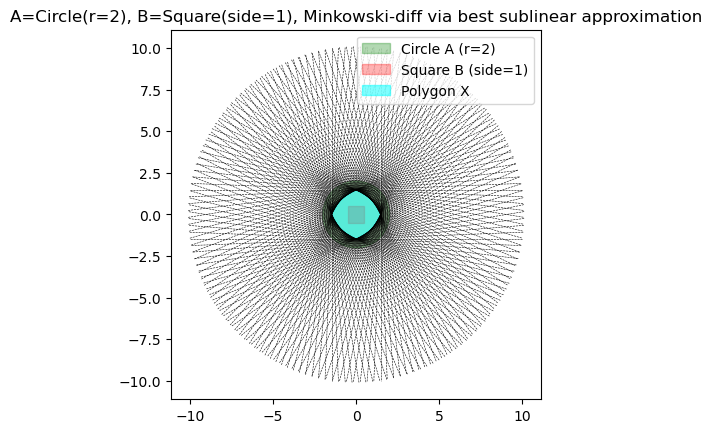

In [15]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

##############################################################################
# 1) Define the Shapes: 
#    A = circle of radius=2 at origin
#    B = square side=1 (centered at origin => corners +/-0.5)
##############################################################################

def support_circle(u, radius=2.0):
    """
    For a circle of radius 'radius', centered at origin:
      h_A(u) = radius * ||u||.
    Since we pass in unit vectors u, h_A(u) = radius.
    """
    return radius  # because ||u||=1

def support_square(u, side=1.0):
    """
    Square with side length 'side', centered at origin => corners are +/- side/2.
    For a direction u=(ux,uy), 
      h_B(u) = (side/2) * (|ux| + |uy|)
    """
    s = side / 2.0
    ux, uy = u
    return s * (abs(ux) + abs(uy))

##############################################################################
# 2) Helper: build intersection of half-planes <x, u_i> <= x_vals[i]
##############################################################################

def build_polygon_from_support(directions, x_vals):
    """
    Intersection of half-planes <x, directions[i]> <= x_vals[i].
    We'll do it in 2D using shapely.
    """
    from shapely.geometry import Polygon
    
    INF = 1e4
    # Start with a huge bounding box
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        # We'll create a large trapezoid that represents
        # the half-plane: <x, u_i> <= alpha
        perp = np.array([-u_i[1], u_i[0]])
        big = 2*INF
        
        # A point on the boundary line <x, u_i> = alpha is p0 = alpha * u_i
        p0 = alpha * u_i
        A = p0 + big*perp
        B = p0 - big*perp
        
        # extend "behind" the line in direction -u_i
        C = A - big*u_i
        D = B - big*u_i
        
        halfplane_poly = Polygon([A, B, D, C])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    
    return region

##############################################################################
# 3) Solve the LP for best sublinear approximation
##############################################################################

def solve_sublinear_approx(f_vals, directions):
    """
    Solve:
      min eps
      s.t.  |x_i - f_i| <= eps,  for i=1..m
            x_k * ||u_i+u_j|| <= x_i + x_j   (subadditivity)
    returns (eps_val, x_vals)
      where x_vals[i] ~ h_X(u_i).
    """
    m = len(directions)
    
    # Create LP
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)
    
    # Decision variables
    eps = pulp.LpVariable('eps', lowBound=0.0)
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None) for i in range(m)]
    
    # Objective
    prob += eps
    
    # Uniform approximation constraints
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps
    
    # Subadditivity
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            w = sum_vec / norm_sum
            # find the best matching direction k
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    if pulp.LpStatus[result] != 'Optimal':
        print("Warning: LP not optimal. status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(xv) for xv in x_vars], dtype=float)
    return eps_val, x_vals

##############################################################################
# 4) Main script: 
#    - define directions
#    - compute f(u)=h_A(u)-h_B(u)
#    - solve LP
#    - build polygon X
#    - plot everything
##############################################################################

def main():
    # 4.1) Directions
    m = 156
    angles = np.linspace(0, 2*np.pi, m, endpoint=False)
    directions = [np.array([np.cos(a), np.sin(a)]) for a in angles]
    
    # 4.2) For each direction, compute f(u)=hA(u)-hB(u)
    # A= circle radius=2 => hA(u)=2
    # B= square side=1 => hB(u)=0.5(|ux|+|uy|)
    f_vals = []
    for d in directions:
        hA = support_circle(d, radius=2.0)
        hB = support_square(d, side=1.0)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals)
    
    # 4.3) Solve the best sublinear approx
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal eps = {eps_val:.6f}")
    
    # 4.4) Build X
    polyX = build_polygon_from_support(directions, x_vals)
    print("X geom_type:", polyX.geom_type)
    print("X is empty? ", polyX.is_empty)
    if not polyX.is_empty:
        print("Area of X:", polyX.area)
    
    # 4.5) Build shapely polygons for A (circle) and B (square) to plot
    # A: circle radius=2
    circle_coords = [(2.0*np.cos(a), 2.0*np.sin(a)) for a in np.linspace(0,2*np.pi,200,endpoint=False)]
    polyA = Polygon(circle_coords)
    
    # B: square side=1 => corners +/-0.5
    half = 0.5
    B_coords = [(-half,-half), ( half,-half), ( half, half), (-half, half)]
    polyB = Polygon(B_coords)
    
    # 4.6) Plot
    fig, ax = plt.subplots()
    
    # Plot A (circle)
    if not polyA.is_empty:
        xA, yA = polyA.exterior.xy
        ax.fill(xA, yA, color='green', alpha=0.3, label='Circle A (r=2)')
    
    # Plot B (square)
    if not polyB.is_empty:
        xB, yB = polyB.exterior.xy
        ax.fill(xB, yB, color='red', alpha=0.3, label='Square B (side=1)')
    
    # Plot X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        elif polyX.geom_type == 'MultiPolygon':
            for g in polyX.geoms:
                xX, yX = g.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5, label='X (sub-polygon)')
        elif polyX.geom_type == 'Point':
            px, py = polyX.x, polyX.y
            ax.plot(px, py, 'bo', label='X = point')
    
    # Optionally draw dashed lines <x,d> = x_vals[i]
    for i,d in enumerate(directions):
        p0 = x_vals[i]*d
        perp = np.array([-d[1], d[0]])
        length = 10
        A_ = p0 + length*perp
        B_ = p0 - length*perp
        ax.plot([A_[0], B_[0]], [A_[1], B_[1]], 'k--', lw=0.4)
    
    ax.set_aspect('equal', 'box')
    ax.set_title("A=Circle(r=2), B=Square(side=1), Minkowski-diff via best sublinear approximation")
    ax.legend()
    plt.show()

if __name__=="__main__":
    main()


Optimal epsilon = 0.233368

Polygon A vertices:
(0.0, 0.0)
(4.0, 0.0)
(6.0, 2.0)
(3.0, 4.0)
(1.0, 2.0)
(0.0, 0.0)

Polygon B vertices:
(-0.5, -0.5)
(0.5, -0.5)
(0.5, 0.5)
(-0.5, 0.5)
(-0.5, -0.5)

Polygon X vertices:
(0.618, 0.267)
(0.618, 0.267)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(3.276, 3.267)
(3.276, 3.267)
(3.276, 3.267)
(3.276, 3.267)
(5.267, 1.937)
(5.267, 1.937)
(5.267, 1.937)
(4.069, 1.136)
(3.382, 0.702)
(3.382, 0.702)
(1.646, 0.267)
(1.646, 0.267)
(0.618, 0.267)
(0.618, 0.267)


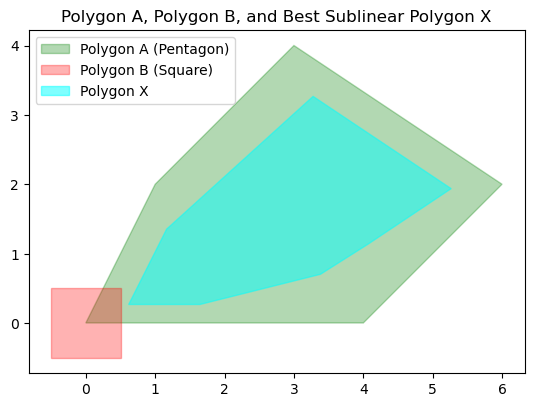

In [2]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# ------------------------------------------------------------------------
# 1) Define the polygons (A: pentagon, B: square)
#    Coordinates are given in (roughly) counterclockwise order.
# ------------------------------------------------------------------------
A_coords = [(0, 0), (4, 0), (6, 2), (3, 4), (1, 2)]  # Polygon A (pentagon)
B_coords = [(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)]  # Polygon B (square)

polyA = Polygon(A_coords)
polyB = Polygon(B_coords)

# ------------------------------------------------------------------------
# 2) Support function for a polygon in 2D
# ------------------------------------------------------------------------
def support_polygon(u, coords):
    """
    Computes the support function h(u)=max_{v in coords} <u,v>.
    """
    return max(np.dot(u, v) for v in coords)

# ------------------------------------------------------------------------
# 3) Sample directions on the unit circle
# ------------------------------------------------------------------------
def sample_directions(num_dirs=64):
    """
    Return a list of 'num_dirs' unit vectors evenly spaced around the circle.
    """
    angles = np.linspace(0, 2 * np.pi, num_dirs, endpoint=False)
    return [np.array([np.cos(a), np.sin(a)]) for a in angles]

# ------------------------------------------------------------------------
# 4) Solve the "best sublinear approximation" LP
# ------------------------------------------------------------------------
def solve_sublinear_approx(f_vals, directions):
    """
    Given values f_vals[i] = f(u_i) and corresponding unit directions,
    solve for x-values approximating the support function of X.
    Returns (eps_value, x_vals) where eps is the optimal uniform error.
    """
    m = len(directions)
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)

    # Decision variables: eps and x_vars[i] ~ h_X(u_i)
    eps = pulp.LpVariable('eps', lowBound=0.0)
    x_vars = [pulp.LpVariable(f"x_{i}") for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps for each direction
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps

    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            # Normalize the sum vector to find the corresponding direction
            w = sum_vec / norm_sum  
            # Find the closest sampled direction to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(var) for var in x_vars], dtype=float)
    return eps_val, x_vals

# ------------------------------------------------------------------------
# 5) Build polygon X from the computed support function values x_vals
# ------------------------------------------------------------------------
def build_polygon_from_support(directions, x_vals):
    """
    Computes the intersection of half-planes defined by <x,u_i> <= x_vals[i].
    Returns a shapely Polygon (or MultiPolygon) representing X.
    """
    INF = 1e4  # A large number to approximate an "infinite" region
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2 * INF
        # A point on the supporting line
        p0 = alpha * u_i
        # Define two points far along the perpendicular direction
        A_ = p0 + big * perp
        B_ = p0 - big * perp
        # Extend these points along -u_i to form a half-plane polygon
        C = A_ - big * u_i
        D = B_ - big * u_i
        
        halfplane_poly = Polygon([tuple(A_), tuple(B_), tuple(D), tuple(C)])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    return region

# ------------------------------------------------------------------------
# 6) Main function: compute & print coordinates, and optionally plot.
# ------------------------------------------------------------------------
def main():
    # Sample directions (using 256 directions for a finer approximation)
    directions = sample_directions(num_dirs=256)
    
    # Compute f(u) = h_A(u) - h_B(u) for each direction u
    f_vals = []
    for d in directions:
        hA = support_polygon(d, A_coords)
        hB = support_polygon(d, B_coords)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # Solve the LP to get the best sublinear approximation (i.e. support function of X)
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}\n")
    
    # Build polygon X from the computed support values
    polyX = build_polygon_from_support(directions, x_vals)
    
    # --------------------------------------------------------------------
    # Print the coordinates of Polygon A, Polygon B, and Polygon X.
    # --------------------------------------------------------------------
    print("Polygon A vertices:")
    # polyA.exterior.coords returns a sequence of (x, y) tuples
    for coord in polyA.exterior.coords:
        print(coord)
    
    print("\nPolygon B vertices:")
    for coord in polyB.exterior.coords:
        print(coord)
    
    if polyX.is_empty:
        print("\nPolygon X is empty.")
    else:
        # polyX may be a Polygon or a MultiPolygon.
        if polyX.geom_type == 'Polygon':
            print("\nPolygon X vertices:")
            for coord in polyX.exterior.coords:
                # Format the coordinates to three decimals
                print(f"({coord[0]:.3f}, {coord[1]:.3f})")
        else:
            print("\nPolygon X is a MultiPolygon:")
            for i, poly in enumerate(polyX.geoms):
                print(f"\nComponent {i + 1} vertices:")
                for coord in poly.exterior.coords:
                    print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Optional: Plot the polygons A, B, and X.
    # --------------------------------------------------------------------
    fig, ax = plt.subplots()
    
    # Plot Polygon A (pentagon)
    xA, yA = polyA.exterior.xy
    ax.fill(xA, yA, color='green', alpha=0.3, label='Polygon A (Pentagon)')
    
    # Plot Polygon B (square)
    xB, yB = polyB.exterior.xy
    ax.fill(xB, yB, color='red', alpha=0.3, label='Polygon B (Square)')
    
    # Plot Polygon X (if non-empty)
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        else:
            for geom in polyX.geoms:
                xX, yX = geom.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5)
    
    ax.set_aspect('equal', 'box')
    ax.set_title("Polygon A, Polygon B, and Best Sublinear Polygon X")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()


Optimal epsilon = 0.233368

Polygon A vertices:
(0.0, 0.0)
(4.0, 0.0)
(6.0, 2.0)
(3.0, 4.0)
(1.0, 2.0)
(0.0, 0.0)

Polygon B vertices:
(-0.5, -0.5)
(0.5, -0.5)
(0.5, 0.5)
(-0.5, 0.5)
(-0.5, -0.5)

Polygon X vertices:
(0.618, 0.267)
(0.618, 0.267)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(3.276, 3.267)
(3.276, 3.267)
(3.276, 3.267)
(3.276, 3.267)
(5.267, 1.937)
(5.267, 1.937)
(5.267, 1.937)
(4.069, 1.136)
(3.382, 0.702)
(3.382, 0.702)
(1.646, 0.267)
(1.646, 0.267)
(0.618, 0.267)
(0.618, 0.267)

Minkowski Sum B+X vertices:
(1.146, -0.233)
(0.118, -0.233)
(0.118, 0.767)
(0.118, 0.767)
(0.118, 0.767)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(2.776, 3.767)
(2.776, 3.767)
(3.776, 3.767)
(3.776, 3.767)
(3.776, 3.767)
(5.767, 2.437)
(5.767, 2.437)
(5.767, 1.437)
(5.767, 1.437)
(4.569, 0.636)
(3.882, 0.202)
(3.882, 0.202)
(2.146, -0.233)
(2.146, -0.233)
(1.146, -0.233)


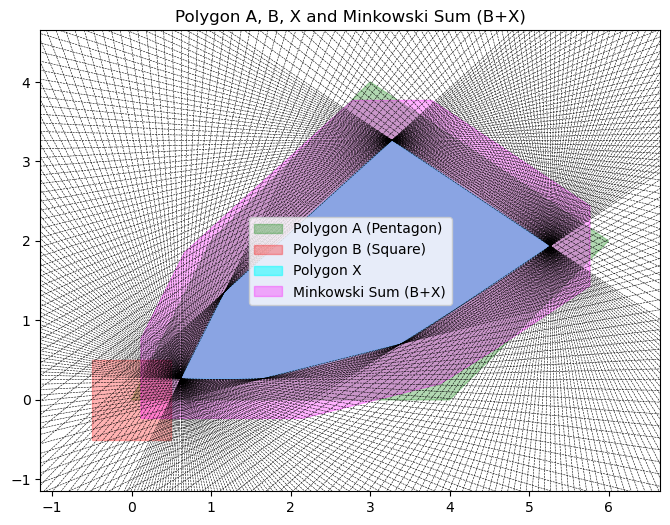

In [3]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint
from shapely import affinity

# ------------------------------------------------------------------------
# 1) Define the polygons (A: pentagon, B: square)
#    Coordinates are given in (roughly) counterclockwise order.
# ------------------------------------------------------------------------
A_coords = [(0, 0), (4, 0), (6, 2), (3, 4), (1, 2)]  # Polygon A (pentagon)
B_coords = [(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)]  # Polygon B (square)

polyA = Polygon(A_coords)
polyB = Polygon(B_coords)

# ------------------------------------------------------------------------
# 2) Support function for a polygon in 2D
# ------------------------------------------------------------------------
def support_polygon(u, coords):
    """
    Computes the support function h(u)=max_{v in coords} <u,v>.
    """
    return max(np.dot(u, v) for v in coords)

# ------------------------------------------------------------------------
# 3) Sample directions on the unit circle
# ------------------------------------------------------------------------
def sample_directions(num_dirs=64):
    """
    Return a list of 'num_dirs' unit vectors evenly spaced around the circle.
    """
    angles = np.linspace(0, 2 * np.pi, num_dirs, endpoint=False)
    return [np.array([np.cos(a), np.sin(a)]) for a in angles]

# ------------------------------------------------------------------------
# 4) Solve the "best sublinear approximation" LP
# ------------------------------------------------------------------------
def solve_sublinear_approx(f_vals, directions):
    """
    Given values f_vals[i] = f(u_i) and corresponding unit directions,
    solve for x-values approximating the support function of X.
    Returns (eps_value, x_vals) where eps is the optimal uniform error.
    """
    m = len(directions)
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)

    # Decision variables: eps and x_vars[i] ~ h_X(u_i)
    eps = pulp.LpVariable('eps', lowBound=0.0)
    x_vars = [pulp.LpVariable(f"x_{i}") for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps for each direction
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps

    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            # Normalize the sum vector to find the corresponding direction
            w = sum_vec / norm_sum  
            # Find the closest sampled direction to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(var) for var in x_vars], dtype=float)
    return eps_val, x_vals

# ------------------------------------------------------------------------
# 5) Build polygon X from the computed support function values x_vals
# ------------------------------------------------------------------------
def build_polygon_from_support(directions, x_vals):
    """
    Computes the intersection of half-planes defined by <x,u_i> <= x_vals[i].
    Returns a shapely Polygon (or MultiPolygon) representing X.
    """
    INF = 1e4  # A large number to approximate an "infinite" region
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2 * INF
        # A point on the supporting line
        p0 = alpha * u_i
        # Define two points far along the perpendicular direction
        A_ = p0 + big * perp
        B_ = p0 - big * perp
        # Extend these points along -u_i to form a half-plane polygon
        C = A_ - big * u_i
        D = B_ - big * u_i
        
        halfplane_poly = Polygon([tuple(A_), tuple(B_), tuple(D), tuple(C)])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    return region

# ------------------------------------------------------------------------
# 6) Compute Minkowski sum of two polygons
# ------------------------------------------------------------------------
def minkowski_sum(poly1, poly2):
    """
    Computes the Minkowski sum of two convex polygons poly1 and poly2.
    The sum is defined as {p + q : p in poly1, q in poly2}.
    Here we compute the sum of all pairs of vertices and then take the convex hull.
    """
    # Get coordinates from the exterior (ignore the closing duplicate)
    coords1 = list(poly1.exterior.coords)[:-1]
    coords2 = list(poly2.exterior.coords)[:-1]
    sum_points = [(p[0] + q[0], p[1] + q[1]) for p in coords1 for q in coords2]
    return MultiPoint(sum_points).convex_hull

# ------------------------------------------------------------------------
# 7) Main function: compute, print coordinates, and plot everything.
# ------------------------------------------------------------------------
def main():
    # Sample directions (using 256 directions for a finer approximation)
    directions = sample_directions(num_dirs=256)
    
    # Compute f(u) = h_A(u) - h_B(u) for each direction u
    f_vals = []
    for d in directions:
        hA = support_polygon(d, A_coords)
        hB = support_polygon(d, B_coords)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # Solve the LP to get the best sublinear approximation (i.e. support function of X)
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}\n")
    
    # Build polygon X from the computed support values
    polyX = build_polygon_from_support(directions, x_vals)
    
    # --------------------------------------------------------------------
    # Print the coordinates of Polygon A, Polygon B, and Polygon X.
    # --------------------------------------------------------------------
    print("Polygon A vertices:")
    for coord in polyA.exterior.coords:
        print(coord)
    
    print("\nPolygon B vertices:")
    for coord in polyB.exterior.coords:
        print(coord)
    
    if polyX.is_empty:
        print("\nPolygon X is empty.")
    else:
        if polyX.geom_type == 'Polygon':
            print("\nPolygon X vertices:")
            for coord in polyX.exterior.coords:
                print(f"({coord[0]:.3f}, {coord[1]:.3f})")
        else:
            print("\nPolygon X is a MultiPolygon:")
            for i, geom in enumerate(polyX.geoms):
                print(f"\nComponent {i + 1} vertices:")
                for coord in geom.exterior.coords:
                    print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Compute Minkowski sum B+X if X is non-empty.
    # --------------------------------------------------------------------
    if polyX.is_empty:
        poly_minkowski = None
        print("\nMinkowski sum B+X cannot be computed because X is empty.")
    else:
        if polyX.geom_type == 'Polygon':
            poly_minkowski = minkowski_sum(polyB, polyX)
        else:
            # If X is a MultiPolygon, take the union first (it should be convex anyway)
            polyX_union = polyX.convex_hull
            poly_minkowski = minkowski_sum(polyB, polyX_union)
        
        print("\nMinkowski Sum B+X vertices:")
        for coord in poly_minkowski.exterior.coords:
            print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Plot the polygons A, B, X, and Minkowski sum (B+X).
    # --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot Polygon A (pentagon)
    xA, yA = polyA.exterior.xy
    ax.fill(xA, yA, color='green', alpha=0.3, label='Polygon A (Pentagon)')
    
    # Plot Polygon B (square)
    xB, yB = polyB.exterior.xy
    ax.fill(xB, yB, color='red', alpha=0.3, label='Polygon B (Square)')
    
    # Plot Polygon X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        else:
            for geom in polyX.geoms:
                xX, yX = geom.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5)
    
    # Plot Minkowski sum B+X
    if polyX and poly_minkowski is not None:
        xM, yM = poly_minkowski.exterior.xy
        ax.fill(xM, yM, color='magenta', alpha=0.3, label='Minkowski Sum (B+X)')
    
    # Optional: draw the supporting lines for visualization
    for i, d in enumerate(directions):
        p0 = x_vals[i] * d
        perp = np.array([-d[1], d[0]])
        L = 100
        A_line = p0 + L * perp
        B_line = p0 - L * perp
        ax.plot([A_line[0], B_line[0]], [A_line[1], B_line[1]], 'k--', lw=0.4)
    
    ax.set_aspect('equal', 'box')
    ax.set_title("Polygon A, B, X and Minkowski Sum (B+X)")
    ax.legend()
    
    # Zoom in: compute union of all shapes
    union_all = polyA.union(polyB)
    if not polyX.is_empty:
        union_all = union_all.union(polyX)
    if poly_minkowski is not None:
        union_all = union_all.union(poly_minkowski)
    
    minx, miny, maxx, maxy = union_all.bounds
    margin = 0.1 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - margin, maxx + margin)
    ax.set_ylim(miny - margin, maxy + margin)
    
    plt.show()

if __name__ == "__main__":
    main()


Optimal epsilon = 0.233368

Polygon A vertices:
(0.000, 0.000)
(4.000, 0.000)
(6.000, 2.000)
(3.000, 4.000)
(1.000, 2.000)
(0.000, 0.000)

Polygon B vertices:
(-0.500, -0.500)
(0.500, -0.500)
(0.500, 0.500)
(-0.500, 0.500)
(-0.500, -0.500)

Polygon X vertices:
(0.618, 0.267)
(0.618, 0.267)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(1.165, 1.353)
(3.276, 3.267)
(3.276, 3.267)
(3.276, 3.267)
(3.276, 3.267)
(5.267, 1.937)
(5.267, 1.937)
(5.267, 1.937)
(4.069, 1.136)
(3.382, 0.702)
(3.382, 0.702)
(1.646, 0.267)
(1.646, 0.267)
(0.618, 0.267)
(0.618, 0.267)

Minkowski Sum (B+X) vertices:
(1.146, -0.233)
(0.118, -0.233)
(0.118, 0.767)
(0.118, 0.767)
(0.118, 0.767)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(0.665, 1.853)
(2.776, 3.767)
(2.776, 3.767)
(3.776, 3.767)
(3.776, 3.767)
(3.776, 3.767)
(5.767, 2.437)
(5.767, 2.437)
(5.767, 1.437)
(5.767, 1.437)
(4.569, 0.636)
(3.882, 0.202)
(3.882, 0.202)
(2.146, -0.233)
(2.146, -0.233)

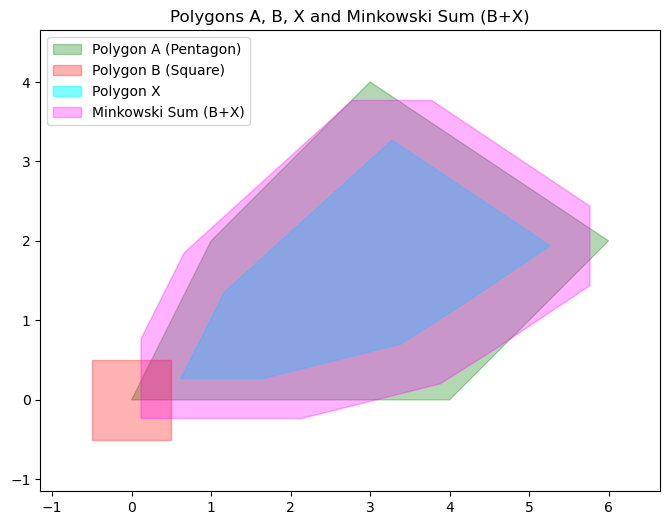

In [4]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint

# ------------------------------------------------------------------------
# 1) Define the polygons (A: pentagon, B: square)
#    Coordinates are given in (roughly) counterclockwise order.
# ------------------------------------------------------------------------
A_coords = [(0, 0), (4, 0), (6, 2), (3, 4), (1, 2)]  # Polygon A (pentagon)
B_coords = [(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)]  # Polygon B (square)

polyA = Polygon(A_coords)
polyB = Polygon(B_coords)

# ------------------------------------------------------------------------
# 2) Support function for a polygon in 2D
# ------------------------------------------------------------------------
def support_polygon(u, coords):
    """
    Computes the support function h(u)=max_{v in coords} <u,v>.
    """
    return max(np.dot(u, v) for v in coords)

# ------------------------------------------------------------------------
# 3) Sample directions on the unit circle
# ------------------------------------------------------------------------
def sample_directions(num_dirs=64):
    """
    Return a list of 'num_dirs' unit vectors evenly spaced around the circle.
    """
    angles = np.linspace(0, 2 * np.pi, num_dirs, endpoint=False)
    return [np.array([np.cos(a), np.sin(a)]) for a in angles]

# ------------------------------------------------------------------------
# 4) Solve the "best sublinear approximation" LP
# ------------------------------------------------------------------------
def solve_sublinear_approx(f_vals, directions):
    """
    Given f_vals[i] = f(u_i) and corresponding unit directions,
    solve for x-values approximating the support function of X.
    Returns (eps_value, x_vals) where eps is the optimal uniform error.
    """
    m = len(directions)
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)

    # Decision variables: eps and x_vars[i] approximating h_X(u_i)
    eps = pulp.LpVariable('eps', lowBound=0.0)
    x_vars = [pulp.LpVariable(f"x_{i}") for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps for each direction
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps

    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            # Normalize the sum vector
            w = sum_vec / norm_sum  
            # Find the closest sampled direction to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(var) for var in x_vars], dtype=float)
    return eps_val, x_vals

# ------------------------------------------------------------------------
# 5) Build polygon X from the computed support function values x_vals
# ------------------------------------------------------------------------
def build_polygon_from_support(directions, x_vals):
    """
    Constructs the intersection of half-planes { x : <x, u_i> <= x_vals[i] }.
    Returns a shapely Polygon (or MultiPolygon) representing X.
    """
    INF = 1e4  # A large number for an "infinite" region
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2 * INF
        # p0 is a point on the line <x,u_i> = alpha
        p0 = alpha * u_i
        # Define two points far along the perpendicular direction
        A_ = p0 + big * perp
        B_ = p0 - big * perp
        # Extend these points along -u_i to form a half-plane polygon
        C = A_ - big * u_i
        D = B_ - big * u_i
        
        halfplane_poly = Polygon([tuple(A_), tuple(B_), tuple(D), tuple(C)])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    return region

# ------------------------------------------------------------------------
# 6) Compute Minkowski sum of two polygons
# ------------------------------------------------------------------------
def minkowski_sum(poly1, poly2):
    """
    Computes the Minkowski sum of two convex polygons poly1 and poly2.
    The sum is defined as { p + q : p in poly1, q in poly2 }.
    We compute the sum of all pairs of vertices and then take the convex hull.
    """
    coords1 = list(poly1.exterior.coords)[:-1]  # exclude the closing point
    coords2 = list(poly2.exterior.coords)[:-1]
    sum_points = [(p[0] + q[0], p[1] + q[1]) for p in coords1 for q in coords2]
    return MultiPoint(sum_points).convex_hull

# ------------------------------------------------------------------------
# 7) Main function: compute, print coordinates, and plot everything.
# ------------------------------------------------------------------------
def main():
    # Sample directions (using 256 directions for a finer approximation)
    directions = sample_directions(num_dirs=256)
    
    # Compute f(u) = h_A(u) - h_B(u) for each direction u
    f_vals = []
    for d in directions:
        hA = support_polygon(d, A_coords)
        hB = support_polygon(d, B_coords)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # Solve the LP to get the best sublinear approximation (i.e. support function of X)
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}\n")
    
    # Build polygon X from the computed support values
    polyX = build_polygon_from_support(directions, x_vals)
    
    # --------------------------------------------------------------------
    # Print the coordinates of Polygon A, Polygon B, and Polygon X.
    # --------------------------------------------------------------------
    print("Polygon A vertices:")
    for coord in polyA.exterior.coords:
        print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    print("\nPolygon B vertices:")
    for coord in polyB.exterior.coords:
        print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    if polyX.is_empty:
        print("\nPolygon X is empty.")
    else:
        if polyX.geom_type == 'Polygon':
            print("\nPolygon X vertices:")
            for coord in polyX.exterior.coords:
                print(f"({coord[0]:.3f}, {coord[1]:.3f})")
        else:
            print("\nPolygon X is a MultiPolygon:")
            for i, geom in enumerate(polyX.geoms):
                print(f"\nComponent {i + 1} vertices:")
                for coord in geom.exterior.coords:
                    print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Compute Minkowski sum B+X if X is non-empty.
    # --------------------------------------------------------------------
    if polyX.is_empty:
        poly_minkowski = None
        print("\nMinkowski sum B+X cannot be computed because X is empty.")
    else:
        # In case X is a MultiPolygon, take its convex hull (should be convex anyway)
        if polyX.geom_type == 'Polygon':
            poly_minkowski = minkowski_sum(polyB, polyX)
        else:
            polyX_union = polyX.convex_hull
            poly_minkowski = minkowski_sum(polyB, polyX_union)
        
        print("\nMinkowski Sum (B+X) vertices:")
        for coord in poly_minkowski.exterior.coords:
            print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Plot the polygons A, B, X, and Minkowski sum (B+X).
    # --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot Polygon A (pentagon)
    xA, yA = polyA.exterior.xy
    ax.fill(xA, yA, color='green', alpha=0.3, label='Polygon A (Pentagon)')
    
    # Plot Polygon B (square)
    xB, yB = polyB.exterior.xy
    ax.fill(xB, yB, color='red', alpha=0.3, label='Polygon B (Square)')
    
    # Plot Polygon X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        else:
            for geom in polyX.geoms:
                xX, yX = geom.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5)
    
    # Plot Minkowski sum (B+X)
    if polyX and poly_minkowski is not None:
        xM, yM = poly_minkowski.exterior.xy
        ax.fill(xM, yM, color='magenta', alpha=0.3, label='Minkowski Sum (B+X)')
    
    ax.set_aspect('equal', 'box')
    ax.set_title("Polygons A, B, X and Minkowski Sum (B+X)")
    ax.legend()
    
    # Zoom in: compute the union of all shapes to set plot limits
    union_all = polyA.union(polyB)
    if not polyX.is_empty:
        union_all = union_all.union(polyX)
    if poly_minkowski is not None:
        union_all = union_all.union(poly_minkowski)
    
    minx, miny, maxx, maxy = union_all.bounds
    margin = 0.1 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - margin, maxx + margin)
    ax.set_ylim(miny - margin, maxy + margin)
    
    plt.show()

if __name__ == "__main__":
    main()


Optimal epsilon = 0.233368

Unique Polygon A vertices:
(0.000, 0.000)
(4.000, 0.000)
(6.000, 2.000)
(3.000, 4.000)
(1.000, 2.000)

Unique Polygon B vertices:
(-0.500, -0.500)
(0.500, -0.500)
(0.500, 0.500)
(-0.500, 0.500)

Unique Polygon X vertices:
(0.618, 0.267)
(1.165, 1.353)
(3.276, 3.267)
(3.276, 3.267)
(5.267, 1.937)
(5.267, 1.937)
(4.069, 1.136)
(3.382, 0.702)
(3.382, 0.702)
(1.646, 0.267)

Unique Minkowski Sum (B+X) vertices:
(1.146, -0.233)
(0.118, -0.233)
(0.118, 0.767)
(0.665, 1.853)
(2.776, 3.767)
(3.776, 3.767)
(3.776, 3.767)
(5.767, 2.437)
(5.767, 2.437)
(5.767, 1.437)
(4.569, 0.636)
(3.882, 0.202)
(3.882, 0.202)
(2.146, -0.233)


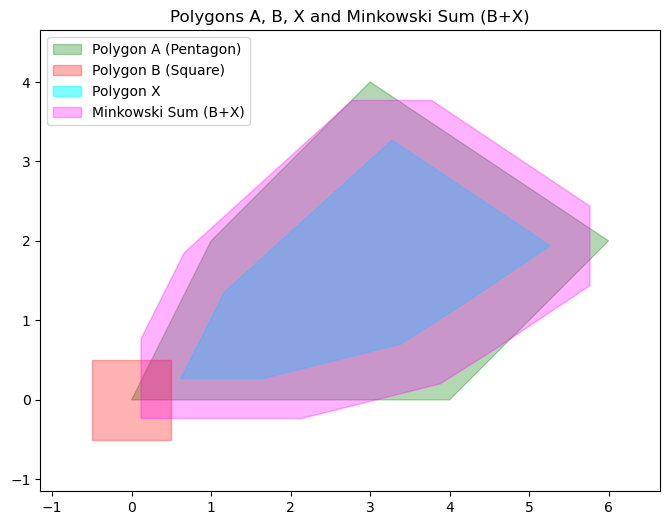

In [3]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint

# ------------------------------------------------------------------------
# 1) Define the polygons (A: pentagon, B: square)
#    Coordinates are given in (roughly) counterclockwise order.
# ------------------------------------------------------------------------
A_coords = [(0, 0), (4, 0), (6, 2), (3, 4), (1, 2)]  # Polygon A (pentagon)
B_coords = [(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)]  # Polygon B (square)

polyA = Polygon(A_coords)
polyB = Polygon(B_coords)

# ------------------------------------------------------------------------
# 2) Support function for a polygon in 2D
# ------------------------------------------------------------------------
def support_polygon(u, coords):
    """
    Computes the support function h(u)=max_{v in coords} <u,v>.
    """
    return max(np.dot(u, v) for v in coords)

# ------------------------------------------------------------------------
# 3) Sample directions on the unit circle
# ------------------------------------------------------------------------
def sample_directions(num_dirs=64):
    """
    Return a list of 'num_dirs' unit vectors evenly spaced around the circle.
    """
    angles = np.linspace(0, 2 * np.pi, num_dirs, endpoint=False)
    return [np.array([np.cos(a), np.sin(a)]) for a in angles]

# ------------------------------------------------------------------------
# 4) Solve the "best sublinear approximation" LP
# ------------------------------------------------------------------------
def solve_sublinear_approx(f_vals, directions):
    """
    Given f_vals[i] = f(u_i) and corresponding unit directions,
    solve for x-values approximating the support function of X.
    Returns (eps_value, x_vals) where eps is the optimal uniform error.
    """
    m = len(directions)
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)

    # Decision variables: eps and x_vars[i] approximating h_X(u_i)
    eps = pulp.LpVariable('eps', lowBound=0.0)
    x_vars = [pulp.LpVariable(f"x_{i}") for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps for each direction
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps

    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            # Normalize the sum vector
            w = sum_vec / norm_sum  
            # Find the closest sampled direction to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(var) for var in x_vars], dtype=float)
    return eps_val, x_vals

# ------------------------------------------------------------------------
# 5) Build polygon X from the computed support function values x_vals
# ------------------------------------------------------------------------
def build_polygon_from_support(directions, x_vals):
    """
    Constructs the intersection of half-planes { x : <x, u_i> <= x_vals[i] }.
    Returns a shapely Polygon (or MultiPolygon) representing X.
    """
    INF = 1e4  # A large number for an "infinite" region
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2 * INF
        # p0 is a point on the line <x,u_i> = alpha
        p0 = alpha * u_i
        # Define two points far along the perpendicular direction
        A_ = p0 + big * perp
        B_ = p0 - big * perp
        # Extend these points along -u_i to form a half-plane polygon
        C = A_ - big * u_i
        D = B_ - big * u_i
        
        halfplane_poly = Polygon([tuple(A_), tuple(B_), tuple(D), tuple(C)])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    return region

# ------------------------------------------------------------------------
# 6) Compute Minkowski sum of two polygons
# ------------------------------------------------------------------------
def minkowski_sum(poly1, poly2):
    """
    Computes the Minkowski sum of two convex polygons poly1 and poly2.
    The sum is defined as { p + q : p in poly1, q in poly2 }.
    We compute the sum of all pairs of vertices and then take the convex hull.
    """
    coords1 = list(poly1.exterior.coords)[:-1]  # exclude the closing point
    coords2 = list(poly2.exterior.coords)[:-1]
    sum_points = [(p[0] + q[0], p[1] + q[1]) for p in coords1 for q in coords2]
    return MultiPoint(sum_points).convex_hull

# ------------------------------------------------------------------------
# A helper function to remove repeated (or nearly identical) vertices.
# ------------------------------------------------------------------------
def get_unique_coords(coords, tol=1e-6):
    unique = []
    for c in coords:
        if not any(np.linalg.norm(np.array(c) - np.array(u)) < tol for u in unique):
            unique.append(c)
    return unique

# ------------------------------------------------------------------------
# 7) Main function: compute, print coordinates, and plot everything.
# ------------------------------------------------------------------------
def main():
    # Sample directions (using 256 directions for a finer approximation)
    directions = sample_directions(num_dirs=256)
    
    # Compute f(u) = h_A(u) - h_B(u) for each direction u
    f_vals = []
    for d in directions:
        hA = support_polygon(d, A_coords)
        hB = support_polygon(d, B_coords)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # Solve the LP to get the best sublinear approximation (i.e. support function of X)
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}\n")
    
    # Build polygon X from the computed support values
    polyX = build_polygon_from_support(directions, x_vals)
    
    # --------------------------------------------------------------------
    # Print the coordinates of Polygon A, Polygon B, and Polygon X.
    # (Filtering out any duplicate vertices)
    # --------------------------------------------------------------------
    print("Unique Polygon A vertices:")
    unique_A = get_unique_coords(list(polyA.exterior.coords)[:-1])
    for coord in unique_A:
        print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    print("\nUnique Polygon B vertices:")
    unique_B = get_unique_coords(list(polyB.exterior.coords)[:-1])
    for coord in unique_B:
        print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    if polyX.is_empty:
        print("\nPolygon X is empty.")
    else:
        if polyX.geom_type == 'Polygon':
            unique_X = get_unique_coords(list(polyX.exterior.coords)[:-1])
            print("\nUnique Polygon X vertices:")
            for coord in unique_X:
                print(f"({coord[0]:.3f}, {coord[1]:.3f})")
        else:
            print("\nPolygon X is a MultiPolygon:")
            for i, geom in enumerate(polyX.geoms):
                unique_X = get_unique_coords(list(geom.exterior.coords)[:-1])
                print(f"\nUnique vertices of Component {i + 1} of Polygon X:")
                for coord in unique_X:
                    print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Compute Minkowski sum B+X if X is non-empty.
    # --------------------------------------------------------------------
    if polyX.is_empty:
        poly_minkowski = None
        print("\nMinkowski sum B+X cannot be computed because X is empty.")
    else:
        # In case X is a MultiPolygon, take its convex hull (should be convex anyway)
        if polyX.geom_type == 'Polygon':
            poly_minkowski = minkowski_sum(polyB, polyX)
        else:
            polyX_union = polyX.convex_hull
            poly_minkowski = minkowski_sum(polyB, polyX_union)
        
        unique_M = get_unique_coords(list(poly_minkowski.exterior.coords)[:-1])
        print("\nUnique Minkowski Sum (B+X) vertices:")
        for coord in unique_M:
            print(f"({coord[0]:.3f}, {coord[1]:.3f})")
    
    # --------------------------------------------------------------------
    # Plot the polygons A, B, X, and Minkowski sum (B+X).
    # --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot Polygon A (pentagon)
    xA, yA = polyA.exterior.xy
    ax.fill(xA, yA, color='green', alpha=0.3, label='Polygon A (Pentagon)')
    
    # Plot Polygon B (square)
    xB, yB = polyB.exterior.xy
    ax.fill(xB, yB, color='red', alpha=0.3, label='Polygon B (Square)')
    
    # Plot Polygon X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        else:
            for geom in polyX.geoms:
                xX, yX = geom.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5)
    
    # Plot Minkowski sum (B+X)
    if polyX and poly_minkowski is not None:
        xM, yM = poly_minkowski.exterior.xy
        ax.fill(xM, yM, color='magenta', alpha=0.3, label='Minkowski Sum (B+X)')
    
    ax.set_aspect('equal', 'box')
    ax.set_title("Polygons A, B, X and Minkowski Sum (B+X)")
    ax.legend()
    
    # Zoom in: compute the union of all shapes to set plot limits
    union_all = polyA.union(polyB)
    if not polyX.is_empty:
        union_all = union_all.union(polyX)
    if poly_minkowski is not None:
        union_all = union_all.union(poly_minkowski)
    
    minx, miny, maxx, maxy = union_all.bounds
    margin = 0.1 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - margin, maxx + margin)
    ax.set_ylim(miny - margin, maxy + margin)
    
    plt.show()

if __name__ == "__main__":
    main()


Optimal epsilon = 0.233368


Unique Polygon A vertices:
(0.000, 0.000)
(1.000, 2.000)
(3.000, 4.000)
(4.000, 0.000)
(6.000, 2.000)

Unique Polygon B vertices:
(-0.500, -0.500)
(-0.500, 0.500)
(0.500, -0.500)
(0.500, 0.500)

Unique Polygon X vertices:
(0.618, 0.267)
(1.165, 1.353)
(1.646, 0.267)
(3.276, 3.267)
(3.276, 3.267)
(3.382, 0.702)
(3.382, 0.702)
(4.069, 1.136)
(5.267, 1.937)
(5.267, 1.937)

Unique Minkowski Sum (B+X) vertices:
(0.118, -0.233)
(0.118, 0.767)
(0.665, 1.853)
(1.146, -0.233)
(2.146, -0.233)
(2.776, 3.767)
(3.776, 3.767)
(3.776, 3.767)
(3.882, 0.202)
(3.882, 0.202)
(4.569, 0.636)
(5.767, 2.437)
(5.767, 1.437)
(5.767, 2.437)


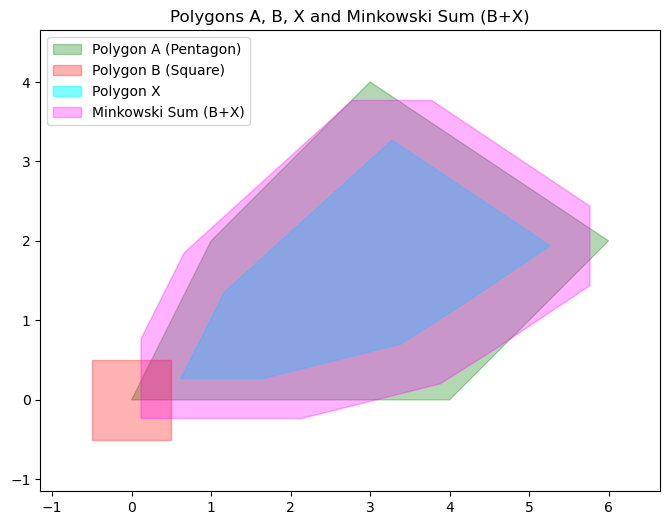

In [4]:
import numpy as np
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint

# ------------------------------------------------------------------------
# 1) Define the polygons (A: pentagon, B: square)
#    Coordinates are given in (roughly) counterclockwise order.
# ------------------------------------------------------------------------
A_coords = [(0, 0), (4, 0), (6, 2), (3, 4), (1, 2)]  # Polygon A (pentagon)
B_coords = [(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)]  # Polygon B (square)

polyA = Polygon(A_coords)
polyB = Polygon(B_coords)

# ------------------------------------------------------------------------
# 2) Support function for a polygon in 2D
# ------------------------------------------------------------------------
def support_polygon(u, coords):
    """
    Computes the support function h(u)=max_{v in coords} <u,v>.
    """
    return max(np.dot(u, v) for v in coords)

# ------------------------------------------------------------------------
# 3) Sample directions on the unit circle
# ------------------------------------------------------------------------
def sample_directions(num_dirs=64):
    """
    Return a list of 'num_dirs' unit vectors evenly spaced around the circle.
    """
    angles = np.linspace(0, 2 * np.pi, num_dirs, endpoint=False)
    return [np.array([np.cos(a), np.sin(a)]) for a in angles]

# ------------------------------------------------------------------------
# 4) Solve the "best sublinear approximation" LP
# ------------------------------------------------------------------------
def solve_sublinear_approx(f_vals, directions):
    """
    Given f_vals[i] = f(u_i) and corresponding unit directions,
    solve for x-values approximating the support function of X.
    Returns (eps_value, x_vals) where eps is the optimal uniform error.
    """
    m = len(directions)
    prob = pulp.LpProblem("BestSublinearApprox2D", pulp.LpMinimize)

    # Decision variables: eps and x_vars[i] approximating h_X(u_i)
    eps = pulp.LpVariable('eps', lowBound=0.0)
    x_vars = [pulp.LpVariable(f"x_{i}") for i in range(m)]
    
    # Objective: minimize eps
    prob += eps, "obj_eps"
    
    # Uniform approximation constraints: |x_i - f_i| <= eps for each direction
    for i in range(m):
        fi = f_vals[i]
        prob += (x_vars[i] - fi) <= eps
        prob += (fi - x_vars[i]) <= eps

    # Subadditivity constraints
    for i in range(m):
        for j in range(m):
            sum_vec = directions[i] + directions[j]
            norm_sum = np.linalg.norm(sum_vec)
            if norm_sum < 1e-9:
                continue
            # Normalize the sum vector
            w = sum_vec / norm_sum  
            # Find the closest sampled direction to w
            best_k = None
            best_dist = 1e9
            for k in range(m):
                dist = np.linalg.norm(directions[k] - w)
                if dist < best_dist:
                    best_dist = dist
                    best_k = k
            if best_dist < 1e-6:
                prob += x_vars[best_k] * norm_sum <= x_vars[i] + x_vars[j]
    
    solver = pulp.PULP_CBC_CMD(msg=0)
    result = prob.solve(solver)
    
    if pulp.LpStatus[result] != "Optimal":
        print("Warning: LP not optimal. Status =", pulp.LpStatus[result])
    
    eps_val = pulp.value(eps)
    x_vals = np.array([pulp.value(var) for var in x_vars], dtype=float)
    return eps_val, x_vals

# ------------------------------------------------------------------------
# 5) Build polygon X from the computed support function values x_vals
# ------------------------------------------------------------------------
def build_polygon_from_support(directions, x_vals):
    """
    Constructs the intersection of half-planes { x : <x, u_i> <= x_vals[i] }.
    Returns a shapely Polygon (or MultiPolygon) representing X.
    """
    INF = 1e4  # A large number for an "infinite" region
    region = Polygon([(-INF, -INF), (INF, -INF), (INF, INF), (-INF, INF)])
    
    for (u_i, alpha) in zip(directions, x_vals):
        perp = np.array([-u_i[1], u_i[0]])
        big = 2 * INF
        # p0 is a point on the line <x,u_i> = alpha
        p0 = alpha * u_i
        # Define two points far along the perpendicular direction
        A_ = p0 + big * perp
        B_ = p0 - big * perp
        # Extend these points along -u_i to form a half-plane polygon
        C = A_ - big * u_i
        D = B_ - big * u_i
        
        halfplane_poly = Polygon([tuple(A_), tuple(B_), tuple(D), tuple(C)])
        region = region.intersection(halfplane_poly)
        if region.is_empty:
            break
    return region

# ------------------------------------------------------------------------
# 6) Compute Minkowski sum of two polygons
# ------------------------------------------------------------------------
def minkowski_sum(poly1, poly2):
    """
    Computes the Minkowski sum of two convex polygons poly1 and poly2.
    The sum is defined as { p + q : p in poly1, q in poly2 }.
    We compute the sum of all pairs of vertices and then take the convex hull.
    """
    coords1 = list(poly1.exterior.coords)[:-1]  # exclude the closing point
    coords2 = list(poly2.exterior.coords)[:-1]
    sum_points = [(p[0] + q[0], p[1] + q[1]) for p in coords1 for q in coords2]
    return MultiPoint(sum_points).convex_hull

# ------------------------------------------------------------------------
# 7) Main function: compute, print coordinates, and plot everything.
# ------------------------------------------------------------------------
def main():
    # Sample directions (using 256 directions for a finer approximation)
    directions = sample_directions(num_dirs=256)
    
    # Compute f(u) = h_A(u) - h_B(u) for each direction u
    f_vals = []
    for d in directions:
        hA = support_polygon(d, A_coords)
        hB = support_polygon(d, B_coords)
        f_vals.append(hA - hB)
    f_vals = np.array(f_vals, dtype=float)
    
    # Solve the LP to get the best sublinear approximation (i.e. support function of X)
    eps_val, x_vals = solve_sublinear_approx(f_vals, directions)
    print(f"Optimal epsilon = {eps_val:.6f}\n")
    
    # Build polygon X from the computed support values
    polyX = build_polygon_from_support(directions, x_vals)
    
    # --------------------------------------------------------------------
    # Print the unique vertices of Polygon A, Polygon B, and Polygon X.
    # Using numpy.unique (after rounding) to derive unique elements.
    # --------------------------------------------------------------------
    def print_unique_vertices(label, coords_array):
        # Round coordinates to 6 decimals and then get unique rows.
        unique = np.unique(np.round(coords_array, decimals=6), axis=0)
        print(f"\nUnique {label} vertices:")
        for c in unique:
            print(f"({c[0]:.3f}, {c[1]:.3f})")
    
    # Polygon A
    coords_A = np.array(polyA.exterior.coords[:-1])
    print_unique_vertices("Polygon A", coords_A)
    
    # Polygon B
    coords_B = np.array(polyB.exterior.coords[:-1])
    print_unique_vertices("Polygon B", coords_B)
    
    # Polygon X
    if polyX.is_empty:
        print("\nPolygon X is empty.")
    else:
        if polyX.geom_type == 'Polygon':
            coords_X = np.array(polyX.exterior.coords[:-1])
            print_unique_vertices("Polygon X", coords_X)
        else:
            print("\nPolygon X is a MultiPolygon:")
            for i, geom in enumerate(polyX.geoms):
                coords_X = np.array(geom.exterior.coords[:-1])
                print_unique_vertices(f"Component {i + 1} of Polygon X", coords_X)
    
    # --------------------------------------------------------------------
    # Compute and print unique vertices of the Minkowski sum B+X (if X is non-empty).
    # --------------------------------------------------------------------
    if polyX.is_empty:
        poly_minkowski = None
        print("\nMinkowski sum B+X cannot be computed because X is empty.")
    else:
        if polyX.geom_type == 'Polygon':
            poly_minkowski = minkowski_sum(polyB, polyX)
        else:
            polyX_union = polyX.convex_hull
            poly_minkowski = minkowski_sum(polyB, polyX_union)
        
        coords_M = np.array(poly_minkowski.exterior.coords[:-1])
        print_unique_vertices("Minkowski Sum (B+X)", coords_M)
    
    # --------------------------------------------------------------------
    # Plot the polygons A, B, X, and Minkowski sum (B+X).
    # --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot Polygon A (pentagon)
    xA, yA = polyA.exterior.xy
    ax.fill(xA, yA, color='green', alpha=0.3, label='Polygon A (Pentagon)')
    
    # Plot Polygon B (square)
    xB, yB = polyB.exterior.xy
    ax.fill(xB, yB, color='red', alpha=0.3, label='Polygon B (Square)')
    
    # Plot Polygon X
    if not polyX.is_empty:
        if polyX.geom_type == 'Polygon':
            xX, yX = polyX.exterior.xy
            ax.fill(xX, yX, color='cyan', alpha=0.5, label='Polygon X')
        else:
            for geom in polyX.geoms:
                xX, yX = geom.exterior.xy
                ax.fill(xX, yX, color='cyan', alpha=0.5)
    
    # Plot Minkowski sum (B+X)
    if polyX and poly_minkowski is not None:
        xM, yM = poly_minkowski.exterior.xy
        ax.fill(xM, yM, color='magenta', alpha=0.3, label='Minkowski Sum (B+X)')
    
    ax.set_aspect('equal', 'box')
    ax.set_title("Polygons A, B, X and Minkowski Sum (B+X)")
    ax.legend()
    
    # Zoom in: compute the union of all shapes to set plot limits
    union_all = polyA.union(polyB)
    if not polyX.is_empty:
        union_all = union_all.union(polyX)
    if poly_minkowski is not None:
        union_all = union_all.union(poly_minkowski)
    
    minx, miny, maxx, maxy = union_all.bounds
    margin = 0.1 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - margin, maxx + margin)
    ax.set_ylim(miny - margin, maxy + margin)
    
    plt.show()

if __name__ == "__main__":
    main()
